In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as stats
from scipy.stats import pearsonr
import itertools
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

In [40]:
train_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
oil_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
transaction_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
stores_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
holiday_event_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')


#train_df = pd.read_csv('/kaggle/working/traindf_preprocessed.csv')

train_df = train_df.groupby('date')['sales','onpromotion'].sum().reset_index()
print(train_df)

/tmp/ipykernel_409/1297911893.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train_df = train_df.groupby('date')['sales','onpromotion'].sum().reset_index()


            date        sales  onpromotion
0     2013-01-01   2511.61900            0
1     2013-01-02 496092.41794            0
2     2013-01-03 361461.23112            0
3     2013-01-04 354459.67709            0
4     2013-01-05 477350.12123            0
...          ...          ...          ...
1679  2017-08-11 826373.72202        14179
1680  2017-08-12 792630.53508         8312
1681  2017-08-13 865639.67747         9283
1682  2017-08-14 760922.40608         8043
1683  2017-08-15 762661.93594        10605

[1684 rows x 3 columns]


# Autocorrelation Analysis

Autocorrelation is a statistical measure that evaluates the correlation between a time series and its lagged values. Autocorrelation plots, including the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF), serve as valuable tools for identifying significant lag values and potential autoregressive or moving average components within the data.

When the autocorrelation value approaches 1 or -1, it signifies a strong positive or negative autocorrelation, respectively.
Conversely, an autocorrelation value close to 0 indicates a weak or negligible autocorrelation.

In [63]:
sales_series = train_df['sales']
autocorr_values = sales_series.autocorr()
print("Autocorrelation value:", autocorr_values)

Autocorrelation: 0.7676441034457161


### Based on the obtained result, wherein the autocorrelation value is approximately 1 (0.766), it implies the presence of a positive autocorrelation. This positive autocorrelation signifies a connection between the current sales values and the preceding sales values.

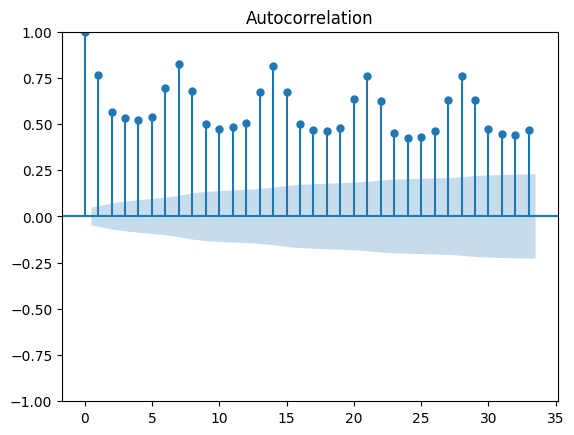

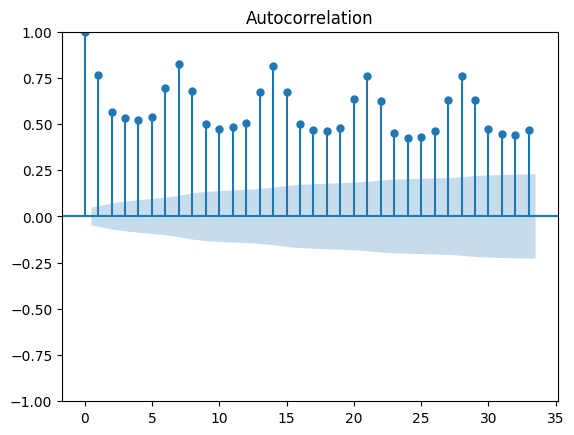

In [64]:
plot_acf(train_df['sales'])

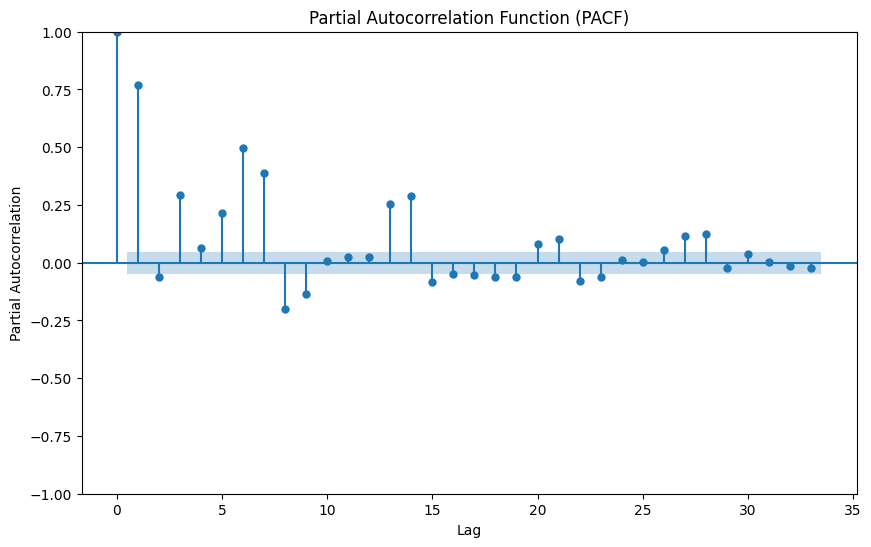

In [66]:
# Plot the PACF values
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(train_df['sales'], ax=ax, method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')

plt.show()

# Differencing technique (ARIMA)

The objective of this process is to convert the time series data into a stationary form, as the ARIMA model is specifically designed to analyze stationary time series data. By achieving stationarity, we ensure that the statistical properties of the data, such as mean and variance, remain constant over time, allowing for more accurate modeling and forecasting using the ARIMA methodology.

In [67]:
train_df['diff_sales'] = train_df['sales'].diff()

In [68]:
train_df = train_df.dropna()

In [69]:
print(train_df['diff_sales'])

3        -7001.55403
4       122890.44414
5        42345.27986
6      -183572.60002
7       -17775.02308
            ...     
1679    174986.81005
1680    -33743.18694
1681     73009.14239
1682   -104717.27139
1683      1739.52986
Name: diff_sales, Length: 1681, dtype: float64


In [70]:
train_df['diff_sales'] = train_df['sales'] - train_df['sales'].shift(1)

In [72]:
# Drop the first row of the df
train_df = train_df.dropna()

In [73]:
print(train_df['diff_sales'])

4       122890.44414
5        42345.27986
6      -183572.60002
7       -17775.02308
8       -15816.96896
            ...     
1679    174986.81005
1680    -33743.18694
1681     73009.14239
1682   -104717.27139
1683      1739.52986
Name: diff_sales, Length: 1680, dtype: float64


In [74]:
train_df.head()

,date,sales,onpromotion,diff_sales
4,2013-01-05,477350.12123,0,122890.44414
5,2013-01-06,519695.40109,0,42345.27986
6,2013-01-07,336122.80107,0,-183572.60002
7,2013-01-08,318347.77798,0,-17775.02308
8,2013-01-09,302530.80902,0,-15816.96896


# Compute the autocorrelation
The "Seasonal Moving Total Autocorrelation Function" (SM.TSA.ACF) is a method utilized in time series analysis that computes the autocorrelation of the seasonal moving totals of a given time series. This technique aids in the identification and examination of seasonal patterns and dependencies present within the data. By analyzing the autocorrelation of these moving totals, valuable insights can be obtained regarding the cyclicality and seasonality of the time series.


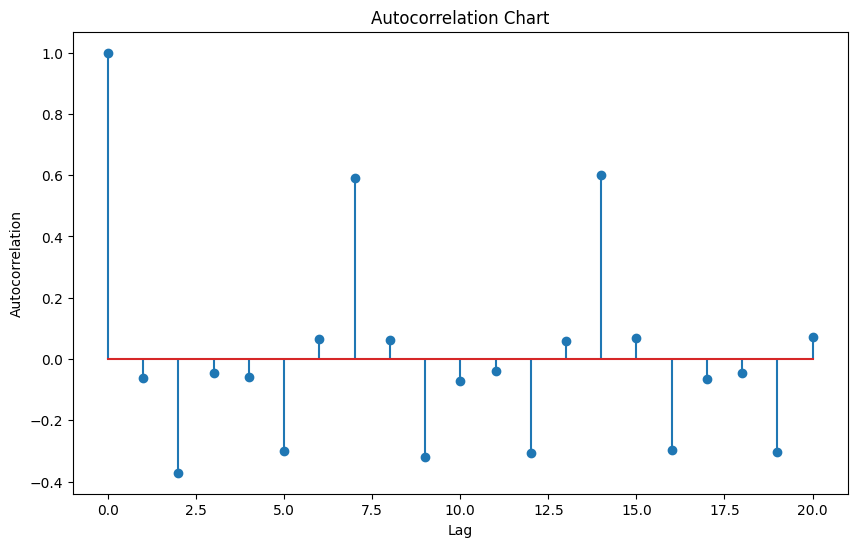

In [77]:

autocorrelation = sm.tsa.acf(train_df['diff_sales'], nlags=20)

# Plot the autocorrelation chart
plt.figure(figsize=(10, 6))
plt.stem(range(len(autocorrelation)), autocorrelation)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Chart')
plt.show()

# Stationarity Test

Several statistical tests are available to assess stationarity in a time series. These tests include the Augmented Dickey-Fuller (ADF) test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test.

The ADF test is used to examine whether a time series possesses a unit root, which indicates non-stationarity. It evaluates the null hypothesis that the series has a unit root against the alternative hypothesis of stationarity. A significant p-value (<0.05) supports the rejection of the null hypothesis and suggests stationarity.

On the other hand, the KPSS test evaluates the null hypothesis that the time series is stationary against the alternative hypothesis of a unit root or non-stationarity. If the p-value is greater than the significance level (>0.05), the null hypothesis of stationarity is not rejected.

These tests provide valuable insights into the stationarity properties of a time series, helping to determine the appropriate modeling techniques and forecasting approaches for the data.

### Augmented Dickey-Fuller (ADF)  test 

The Augmented Dickey-Fuller (ADF) test serves as a statistical test to assess whether a time series is stationary or non-stationary. Stationarity is a crucial assumption in numerous time series analysis models.

The ADF test aims to evaluate the null hypothesis stating that the time series possesses a unit root, indicating non-stationarity. Conversely, the alternative hypothesis suggests that the time series is stationary.

During the ADF test, two key results are obtained: the ADF statistic and the corresponding p-value. The ADF statistic is a negative value, and its magnitude indicates the strength of evidence against the null hypothesis. A more negative ADF statistic signifies stronger evidence supporting stationarity. On the other hand, the p-value represents the probability of observing the ADF statistic or a more extreme value under the assumption that the null hypothesis is true. A low p-value (typically below a significance level of 0.05) indicates substantial evidence against the null hypothesis, suggesting that the time series is stationary.





In [80]:
ts = train_df['diff_sales']

In [81]:
# Perform the ADF test
result = adfuller(ts)

# Extract and print the test statistics and p-value
adf_statistic = result[0]
p_value = result[1]
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

ADF Statistic: -11.494188858715107
p-value: 4.65726908654138e-21


The ADF statistic of -11.494188858715107 obtained for the time series suggests a strong indication against the null hypothesis of non-stationarity. Typically, the ADF statistic is compared to critical values to determine the stationarity of the time series. In this case, as the ADF statistic is significantly lower than the critical values, it provides substantial evidence in favor of stationarity. Therefore, it can be inferred that the time series is likely stationary.

Additionally, the p-value of 4.65726908654138e-21 obtained is extremely small. The p-value represents the probability of obtaining the observed ADF statistic or a more extreme value if the null hypothesis of non-stationarity were true. In this scenario, the small p-value further supports the rejection of the null hypothesis and reinforces the conclusion that the time series is stationary.

In summary, based on the provided ADF statistic and p-value, it can be inferred that the time series analyzed using the ARIMA model is stationary.

### Kwiatkowski-Phillips-Schmidt-Shin (KPSS)

The Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test is an alternative statistical test used to assess the stationarity of a time series. It complements the Augmented Dickey-Fuller (ADF) test in analyzing the stationarity properties of a time series.

The KPSS test evaluates the null hypothesis that the time series is stationary, against the alternative hypothesis of non-stationarity. Unlike the ADF test, which assumes the presence of a unit root, the KPSS test assumes the absence of a unit root.

During the KPSS test, the KPSS statistic is calculated, representing the cumulative sum of squared deviations from the mean in the series. Additionally, a p-value is provided, indicating the probability of observing the KPSS statistic or a more extreme value under the null hypothesis.

Interpreting the results of the KPSS test involves considering the KPSS statistic and the associated p-value. If the KPSS statistic exceeds the critical value at a chosen significance level (such as 0.05), it provides evidence against the null hypothesis of stationarity. Conversely, if the KPSS statistic is smaller than the critical value, it suggests that the time series is stationary.

In [83]:
import warnings
warnings.filterwarnings('ignore')
result = kpss(ts)

# Extract and print the test statistic and p-value
kpss_statistic = result[0]
p_value = result[1]
print("KPSS Statistic:", kpss_statistic)
print("p-value:", p_value)

KPSS Statistic: 0.027796906630968003
p-value: 0.1


The Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test was conducted on the time series data to examine its stationarity properties. The obtained KPSS statistic of 0.0278 indicates a small deviation from the null hypothesis of stationarity. Additionally, the p-value of 0.1 suggests that there is insufficient evidence to reject the null hypothesis. Based on these results, it can be tentatively inferred that the time series exhibits characteristics of stationarity. However, further analysis and consideration of other statistical tests are recommended for a comprehensive assessment of the time series stationarity.

# Final ACF & PACF

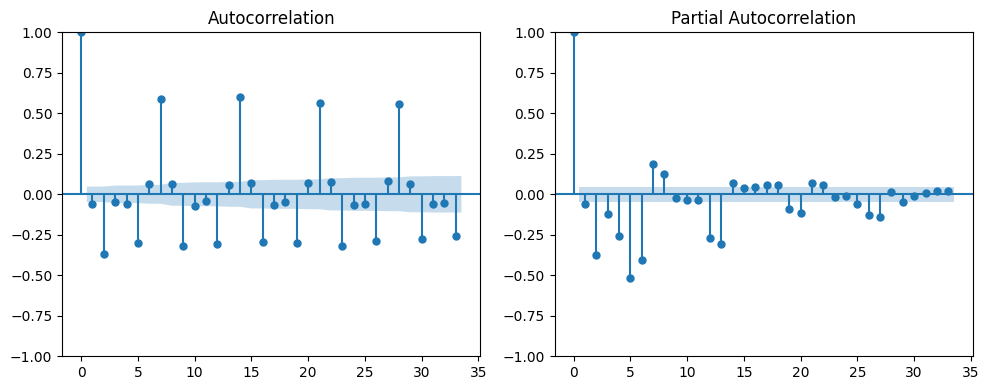

In [84]:
# Plot the Autocorrelation Function (ACF)
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(121)
plot_acf(train_df['diff_sales'], ax=ax1)

# Plot the Partial Autocorrelation Function (PACF)
ax2 = plt.subplot(122)
plot_pacf(train_df['diff_sales'], ax=ax2)

plt.tight_layout()
plt.show()

# Autoregressive Integrated Moving Average Model (ARIMA) model

In [85]:
p = 2

d = 1 

q = 2

In [86]:
train_np = train_df['diff_sales'].values.astype('float64')
model = sm.tsa.ARIMA(train_np, order=(p, d, q))

result = model.fit()

In [87]:
# Print the model summary
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1680
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -22273.482
Date:                Wed, 21 Jun 2023   AIC                          44556.965
Time:                        06:22:41   BIC                          44584.094
Sample:                             0   HQIC                         44567.015
                               - 1680                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5271      0.025     21.490      0.000       0.479       0.575
ar.L2         -0.3419      0.032    -10.632      0.000      -0.405      -0.279
ma.L1         -1.9071      0.020    -97.058      0.0

In [88]:
# Make predictions
start_idx = len(train_np)
end_idx = len(train_np) + len(test_df) - 1
predictions = result.predict(start=start_idx, end=end_idx)

# Print the predictions
print(predictions)

[51894.26540766 26951.3486721  -3342.90380872 ...   234.1740501
   234.1740501    234.1740501 ]


In [89]:
actual_values = train_df['diff_sales']

In [90]:
# Truncate or pad the predictions array to align with the length of actual_values
predictions = predictions[:len(actual_values)]

# Compute evaluation metrics
mean_absolute_error = np.mean(np.abs(predictions - actual_values))
mean_absolute_percentage_error = np.mean(np.abs(predictions - actual_values)/actual_values)

# Display the evaluation metrics
print("Mean Absolute Error (MAE):", mean_absolute_error)
print("Mean Absolute Percentage Error (MAPE):", mean_absolute_percentage_error)

Mean Absolute Error (MAE): 116074.51678360149
Mean Absolute Percentage Error (MAPE): 0.04992100769144455


### The Arima Model with parameters (2,1,2) makes 4.9% error.